<a href="https://colab.research.google.com/github/arcadia420/captcha-classification-project/blob/main/another_shit_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow matplotlib roboflow

import os
from roboflow import Roboflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [2]:
rf = Roboflow(api_key="4uPTPQR4io0oNVtkOdah")
project = rf.workspace("insignia-y6qez").project("recaptcha-ajhol")
version = project.version(2)
dataset = version.download("folder")

dataset_path = "recaptcha-2"
train_dir = os.path.join(dataset_path, "train")
valid_dir = os.path.join(dataset_path, "valid")
test_dir = os.path.join(dataset_path, "test")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to recaptcha-2 in folder:: 100%|██████████| 22640/22640 [00:02<00:00, 9625.96it/s]


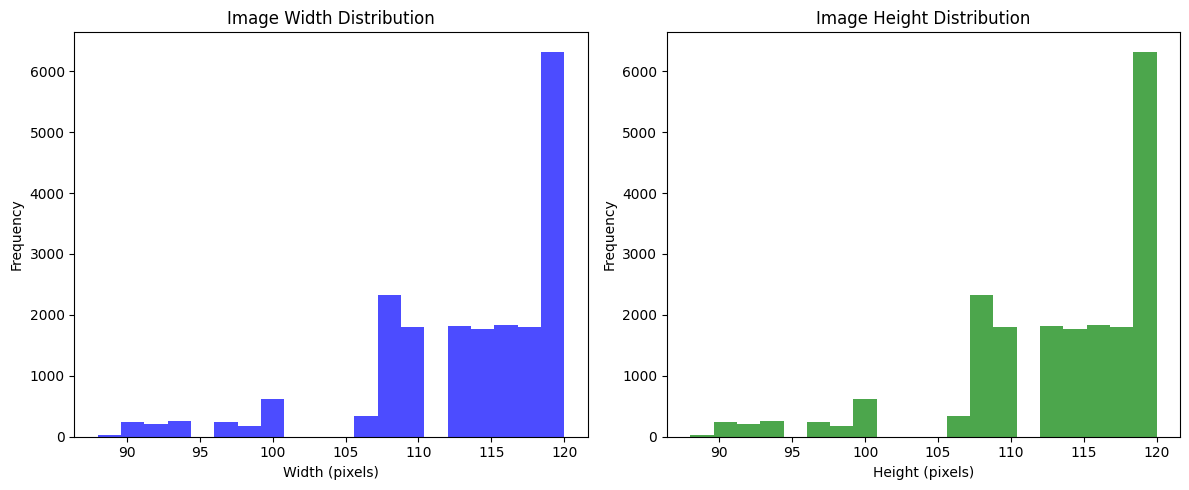

In [3]:
from PIL import Image

def analyze_image_dimensions(directory):
    widths, heights = [], []
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                with Image.open(img_path) as img:
                    widths.append(img.size[0])
                    heights.append(img.size[1])
    return widths, heights

train_widths, train_heights = analyze_image_dimensions(train_dir)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(train_widths, bins=20, color='blue', alpha=0.7)
plt.title("Image Width Distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(train_heights, bins=20, color='green', alpha=0.7)
plt.title("Image Height Distribution")
plt.xlabel("Height (pixels)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [10]:
IMG_SIZE = (128, 128)  # Optimal size based on image analysis

datagen_augmented = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,  # Mild augmentation
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_data = datagen_augmented.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical'
)

valid_data = ImageDataGenerator(rescale=1.0 / 255).flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical'
)

test_data = ImageDataGenerator(rescale=1.0 / 255).flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical'
)


Found 19782 images belonging to 12 classes.
Found 1877 images belonging to 12 classes.
Found 942 images belonging to 12 classes.


In [9]:
# Add the missing class folder in valid and test directories
os.makedirs(os.path.join(valid_dir, "Bicycle Crosswalk"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "Bicycle Crosswalk"), exist_ok=True)

print("Added 'Bicycle Crosswalk' class to valid and test directories")

Added 'Bicycle Crosswalk' class to valid and test directories


In [5]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(train_data.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


In [6]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Wait for 5 epochs of no improvement
    restore_best_weights=True
)


In [11]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=20,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=valid_data.samples // valid_data.batch_size,
    callbacks=[early_stopping]
)


Epoch 1/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 98s 156ms/step - accuracy: 0.5103 - loss: 2.0694 - val_accuracy: 0.5194 - val_loss: 2.0731
Epoch 2/20
  1/618 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5938 - loss: 1.7565

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5938 - loss: 1.7565 - val_accuracy: 0.5238 - val_loss: 2.1297
Epoch 3/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 137s 152ms/step - accuracy: 0.5445 - loss: 1.9528 - val_accuracy: 0.5420 - val_loss: 2.0357
Epoch 4/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 0s 58us/step - accuracy: 0.5625 - loss: 1.8255 - val_accuracy: 0.5238 - val_loss: 2.0044
Epoch 5/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 96s 154ms/step - accuracy: 0.5567 - loss: 1.8630 - val_accuracy: 0.5156 - val_loss: 2.2319
Epoch 6/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 0s 35us/step - accuracy: 0.7188 - loss: 1.6377 - val_accuracy: 0.4762 - val_loss: 2.2229
Epoch 7/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 143s 156ms/step - accuracy: 0.5718 - loss: 1.8423 - val_accuracy: 0.2543 - val_loss: 4.3976
Epoch 8/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5000 - loss: 2.0229 - val_accuracy: 0.1429 - val_loss: 4.4549
Epoch 9/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 96s 154ms/step - accuracy: 0.5998 - loss: 1.9474 - val_accurac

In [12]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}")


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.6067 - loss: 2.2446
Test Accuracy: 0.61


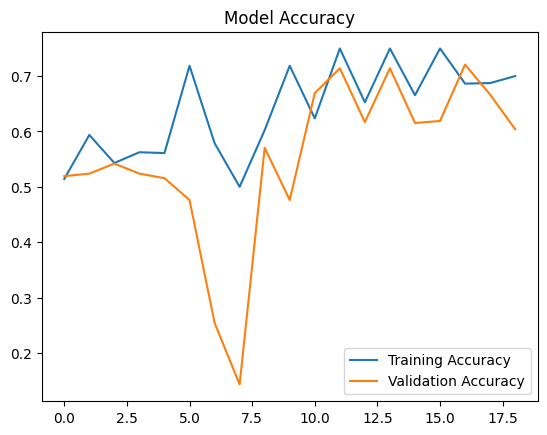

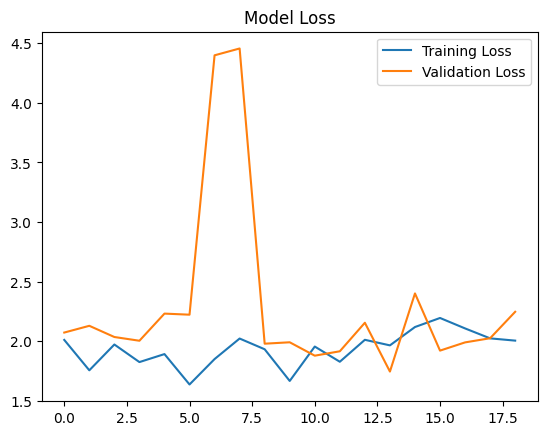

In [13]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [14]:
import numpy as np

# Get the predicted labels
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


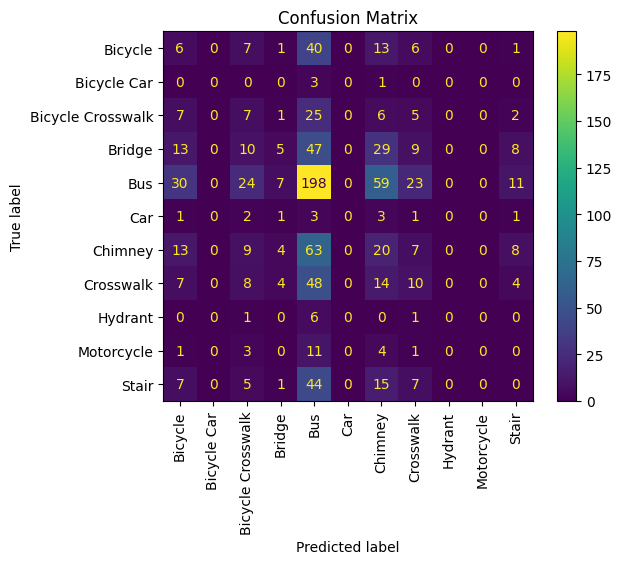

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Ensure class_labels has the same length as the number of classes in the confusion matrix
num_classes = cm.shape[0]  # Get the number of classes from the confusion matrix
class_labels = class_labels[:num_classes]  # Trim class_labels if necessary


# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()